Benjamin Henningsen (bhd505)                                                    29/10 - 2025

# Aggregate inflation in Denmark 1

### Basics 1.1

In [47]:
%%capture
%pip install git+https://github.com/alemartinello/dstapi

In [48]:
# Installing required packages, API and plotting settings
import numpy as np
import pandas as pd

from dstapi import DstApi

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

In [49]:
PRIS113 = DstApi('PRIS113') 
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2026-01-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,552,1980M01,1980M01,2025M12,2025M12,True


In [ ]:
# The data must then be cleaned, since there are no observations for some months.
# First the parameters are downloaded from PRIS113:
params = {
 'table': 'PRIS113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [
 {'code': 'TYPE', 'values': ['INDEKS']},
 {'code': 'TID', 'values': ['*']},
 ]
}
CPI = PRIS113.get_data(params=params)

# The time variable must be converted to datetime format and we can drop irelevant columns:
CPI['date'] = pd.to_datetime(CPI['TID'], format='%YM%m')
CPI['INDHOLD'] = CPI['INDHOLD'].astype(float)
CPI['year'] = CPI['date'].dt.year
CPI = CPI.sort_values('date')
CPI = CPI.drop(columns = 'TYPE')


In [51]:
# To index 2020, we must find the mean value in that exact year using the location method:

CPI_2020 = CPI.loc[CPI['year']==2020, 'INDHOLD'].mean()
CPI['INDEX_2020'] = CPI['INDHOLD'] / CPI_2020 * 100


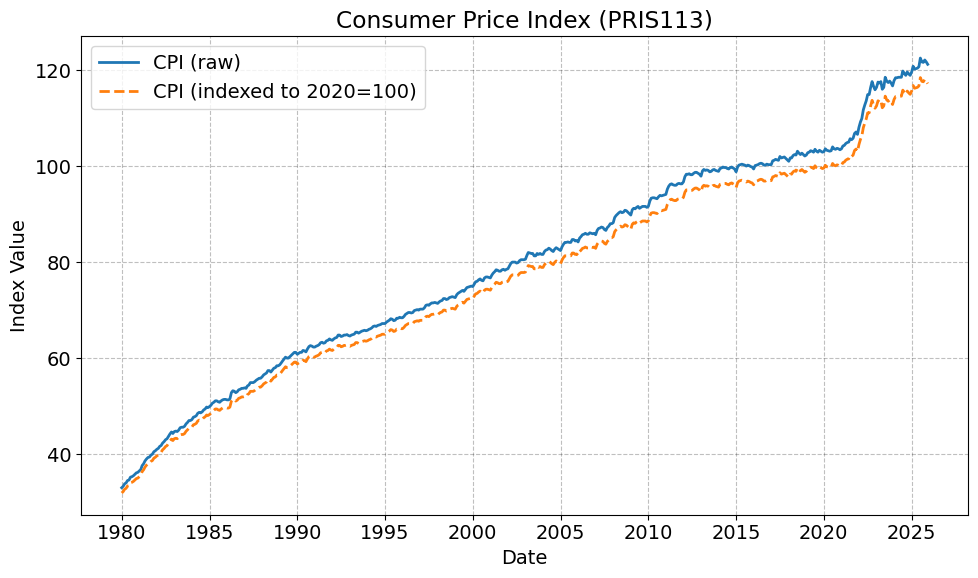

In [52]:
# The new figure can be plotted:

plt.figure(figsize=(10,6))
plt.plot(CPI['date'], CPI['INDHOLD'], label='CPI (raw)', linewidth=2)
plt.plot(CPI['date'], CPI['INDEX_2020'], label='CPI (indexed to 2020=100)', linewidth=2, linestyle='--')

plt.title('Consumer Price Index (PRIS113)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# The pct.change function is used to compute the inflation rate and the yearly inflation rate:

CPI['pi_t'] = CPI['INDHOLD'].pct_change() * 100 # Monthly inflation rate
CPI['pi_12'] = CPI['INDHOLD'].pct_change(periods=12) * 100 # Yearly inflation rate


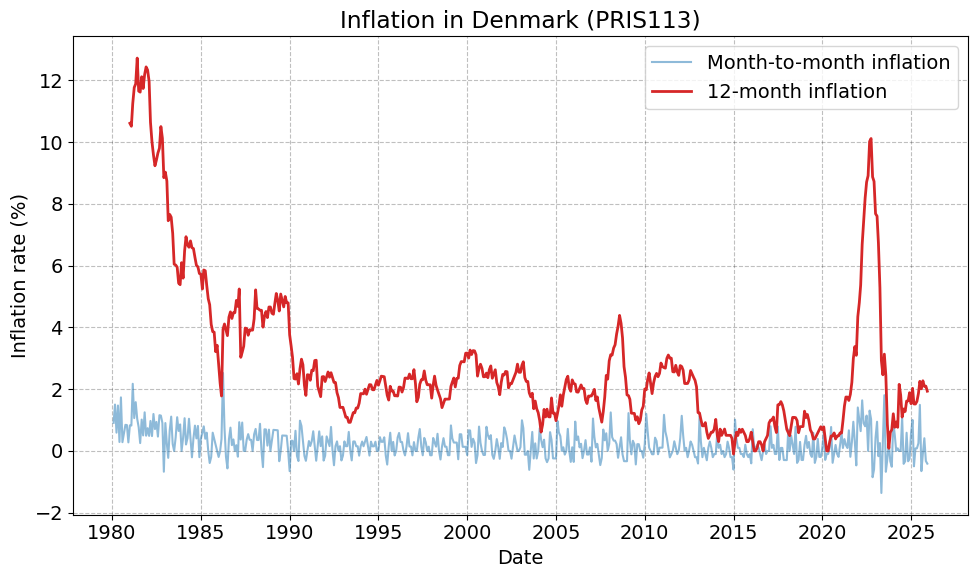

In [54]:
# The figures for these are plotted aswell:

plt.figure(figsize=(10,6))
plt.plot(CPI['date'], CPI['pi_t'], label='Month-to-month inflation', alpha=0.5)
plt.plot(CPI['date'], CPI['pi_12'], label='12-month inflation', linewidth=2, color='tab:red')

plt.title('Inflation in Denmark (PRIS113)')
plt.xlabel('Date')
plt.ylabel('Inflation rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# The figures shows that inflation spiked between 2020 to 2023,
# meaning the inflation surge stopped around 2023

### Instantanious Inaflation 1.2

In [55]:
from math import gamma

# We want to plot the function for different values of alpha and k

# the kappa function defined:
def calculate_kappa(k, alpha, T=11):
    numerator = (T - k) ** alpha
    denominator = sum((T - j) ** alpha for j in range(0, T+1))
    return numerator / denominator


# Calculate the average of the inflation
def calculate_instantaneous_inflation(monthly_inflation_series, alpha):
    if len(monthly_inflation_series) < 12:
        return np.nan
    
    T = 11
    product = 1.0
    
    for k in range(0, 12):
        weight = calculate_kappa(k, alpha, T)
        product *= (1 + monthly_inflation_series.iloc[k]) ** weight
    
    return product - 1



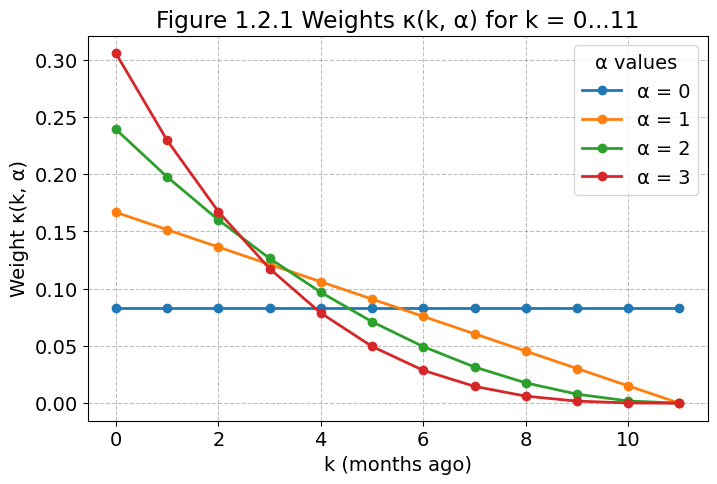

In [56]:
plt.figure(figsize=(8, 5))

for alpha in [0, 1, 2, 3]:
    weights = [calculate_kappa(k, alpha) for k in range(12)]
    plt.plot(np.arange(12), weights, marker='o', linewidth=2, label=f'α = {alpha}')

# --- Formatting the plot ---
plt.title("Figure 1.2.1 Weights κ(k, α) for k = 0...11")
plt.xlabel("k (months ago)")
plt.ylabel("Weight κ(k, α)")
plt.legend(title="α values")
plt.grid(True)
plt.show()

In [57]:
import numpy as np

T = 12

# Define kappa function
def kappa(k, alpha):
    numerator = (T - k)**alpha
    denominator = sum((T - j)**alpha for j in range(T))
    return numerator / denominator

# Define weighted inflation function
def weighted_inflation(series, alpha):
    kappas = np.array([kappa(k, alpha) for k in range(T)])
    values = (1 + series.values / 100)**kappas
    return (np.prod(values) - 1) * 100   

In [58]:
# Specify the for loop, which should compute the weighted inflation for alphas 0,1,2,3
alphas = [0, 1, 2, 3]

for alpha in alphas:
    CPI[f'pi12_alpha{alpha}'] = (
        CPI['pi_t']
        .rolling(12)
        .apply(lambda x: weighted_inflation(x[::-1], alpha), raw=False)
    )


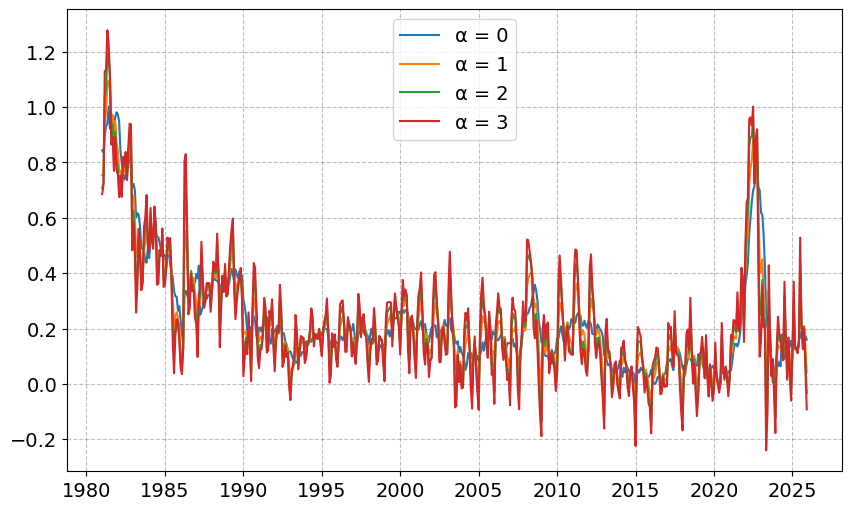

In [59]:
plt.figure(figsize=(10,6))
for alpha in alphas:
    plt.plot(CPI['date'], CPI[f'pi12_alpha{alpha}'], label=f'α = {alpha}')
plt.legend()
plt.grid(True)
plt.show()

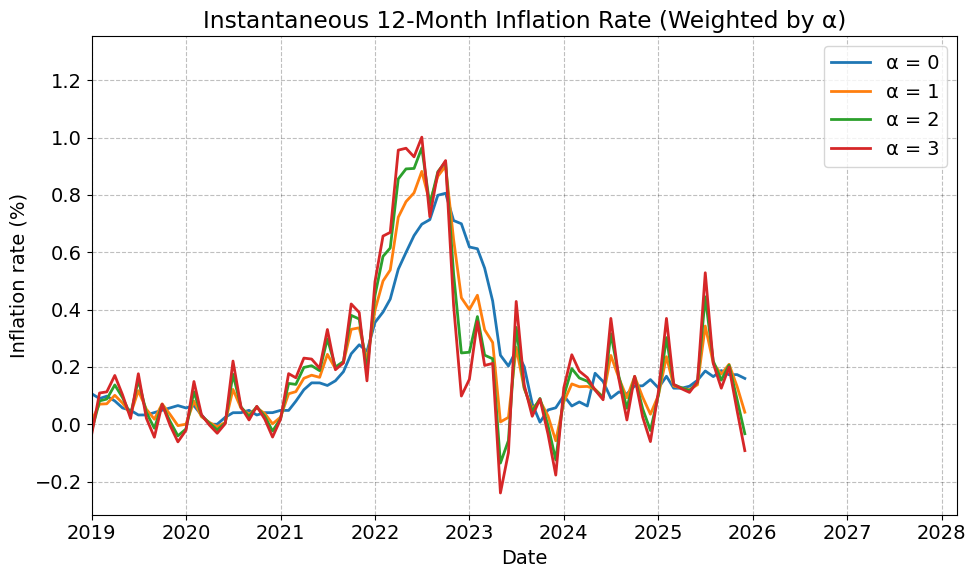

In [60]:
# Lastly, the yearly inflation since 2019 is plotted:
plt.figure(figsize=(10,6))
for alpha in alphas:
    plt.plot(CPI['date'], CPI[f'pi12_alpha{alpha}'], label=f'α = {alpha}', linewidth=2)

plt.title('Instantaneous 12-Month Inflation Rate (Weighted by α)')
plt.xlabel('Date')
plt.ylabel('Inflation rate (%)')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2019-01-01'), None)
plt.tight_layout()
plt.show()

In [ ]:
# The weighted inflation rate compares prices today versus last year,
# which means the data changes more slowly and that it "lags" behind the turnings point.
# The figure suggest, that the inflation surge might've ended in 2024 which is lates than the previous model showed.

### Core Inflation 1.3

In [99]:
# The needed data is downloaded:
PRIS111 = DstApi('PRIS111')

In [ ]:
# We download the parameters of the dataset
def load_PRIS111(VAREGR,ENHED, varname):
 params = {
 'table': 'PRIS111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [
 {'code': 'VAREGR', 'values': [VAREGR]},
 {'code': 'ENHED', 'values': [ENHED]},
 {'code': 'TID', 'values': ['*']},
 ]
 } 

 df = DstApi('PRIS111').get_data(params=params)

 df['date'] = pd.to_datetime(df['TID'], format='%YM%m')
 df['INDHOLD'] = df['INDHOLD'].astype(float)
 df['INDHOLD'] = df['INDHOLD'].pct_change(12)*100
 df = df.rename(columns={'INDHOLD': varname})
 df = df.drop(columns=['VAREGR','ENHED', 'TID'])
 df = df.set_index('date').sort_index()

 return df[[varname]] # Return single varname


In [ ]:
# We then must define the variables:
df_total = load_PRIS111('000000', '100', 'Total')
df_excl_energy = load_PRIS111('151000','100', 'Excl_energy')
df_core = load_PRIS111('141000','100','Core')

# Combine into one DataFrame
CPI = pd.concat([df_total, df_excl_energy, df_core], axis=1)

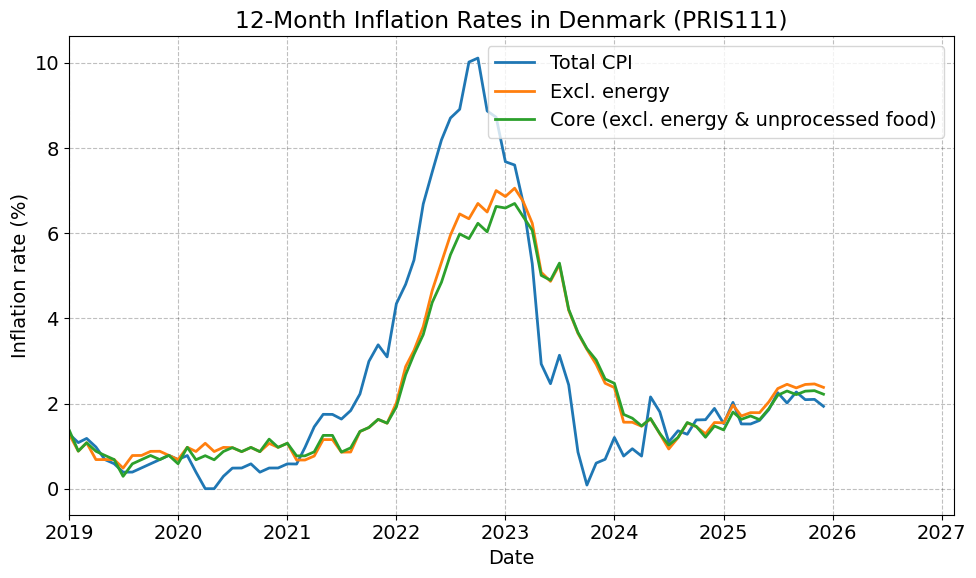

In [ ]:
# We can then plot the development of the different price indexes

plt.figure(figsize=(10,6))
plt.plot(CPI.index, CPI['Total'], label='Total CPI', linewidth=2)
plt.plot(CPI.index, CPI['Excl_energy'], label='Excl. energy', linewidth=2)
plt.plot(CPI.index, CPI['Core'], label='Core (excl. energy & unprocessed food)', linewidth=2)

plt.title('12-Month Inflation Rates in Denmark (PRIS111)')
plt.xlabel('Date')
plt.ylabel('Inflation rate (%)')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2019-01-01'), None)
plt.tight_layout()
plt.show()

In [66]:
# From this figure we can see that inflation excluding energy and core have approx the same trend.
# The total inflation is more volatile, and it can see be seen that it spikes more during, and then falls more rapidly after
# This could suggest that unprocessed food wasnt a main driver, since core and excl. energy are similar.

### Disaggregated inflation in Denmark 1.4

In [67]:
# Using the provided code, we can show some of the product codes:

levels = PRIS111.variable_levels('VAREGR', language='en')

for row in levels.head(5).itertuples(): # We limit to first 5 rows for brevity
    print(row.id, row.text)

000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice


In [68]:
# We download the data for all product categories:
params = {
 'table': 'PRIS111',
 'format': 'BULK',
 'lang': 'en',
 'variables': [
 {'code': 'VAREGR', 'values': ['*']},
 {'code': 'ENHED', 'values': ['100']},
 {'code': 'Tid', 'values': ['*']}
 ]
}
df = PRIS111.get_data(params=params, as_DataFrame=True)

In [69]:
# The data is cleaned
df = df.rename(columns={'TID': 'date', 'INDHOLD': 'CPI'})
df['date'] = pd.to_datetime(df['date'], format='%YM%m')
df['CPI'] = df['CPI'].replace('..', np.nan).astype(float)
df = df.sort_values(['VAREGR', 'date'])

In [70]:
# Compute 12-month inflation rate:
df['pi_12'] = df.groupby('VAREGR')['CPI'].pct_change(periods=12) * 100

/var/folders/z7/tgkq7pjx7tvb8lys3k1y4ffw0000gn/T/ipykernel_56658/902999146.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['pi_12'] = df.groupby('VAREGR')['CPI'].pct_change(periods=12) * 100


In [71]:
# Compute percentiles of inflation rates across product categories for each date
inflation_stats = df.groupby('date')['pi_12'].agg(
    p25=lambda x: x.quantile(0.25),
    median='median',
    p75=lambda x: x.quantile(0.75)
)

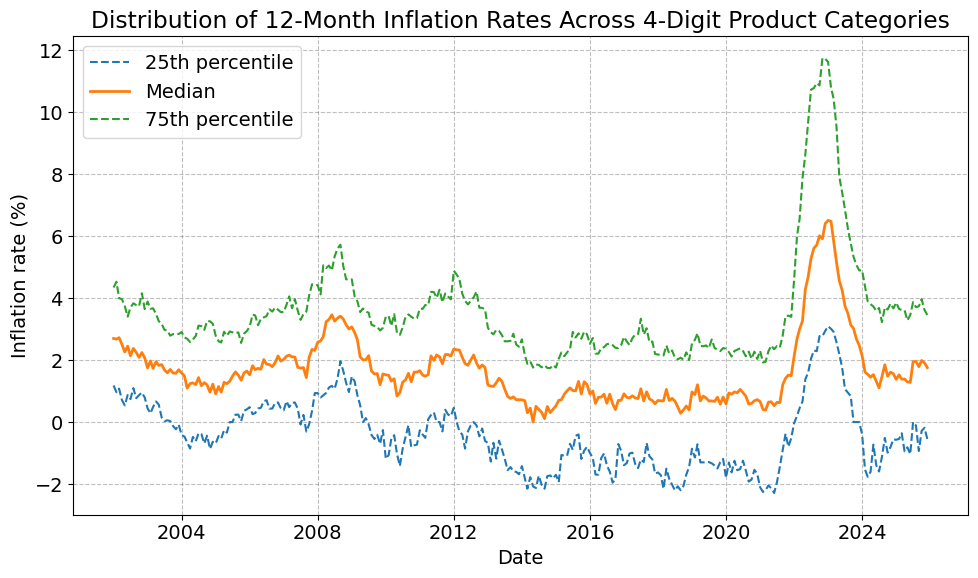

In [72]:
# Lastly we plot the data

plt.figure(figsize=(10,6))
plt.plot(inflation_stats.index, inflation_stats['p25'], label='25th percentile', linestyle='--')
plt.plot(inflation_stats.index, inflation_stats['median'], label='Median', linewidth=2)
plt.plot(inflation_stats.index, inflation_stats['p75'], label='75th percentile', linestyle='--')

plt.title('Distribution of 12-Month Inflation Rates Across 4-Digit Product Categories')
plt.xlabel('Date')
plt.ylabel('Inflation rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# The figure shows, that the different percentiles are experiencing the same trend, and that distance seems to be equal throughout the period
# Under the inflation surge around 2020, we see that distance between the percentiles increase, likely because of outliers.

In [74]:
# We plot histograms from August 2020 to August 2025

df_2020 = df[df['date'] == '2020-08-01'][['VAREGR', 'CPI']].rename(columns={'CPI': 'CPI_2020'})
df_2025 = df[df['date'] == '2025-08-01'][['VAREGR', 'CPI']].rename(columns={'CPI': 'CPI_2025'})

# Merge and compute percent change
merged = pd.merge(df_2020, df_2025, on='VAREGR', how='inner')
merged['pct_change'] = (merged['CPI_2025'] / merged['CPI_2020'] - 1) * 100


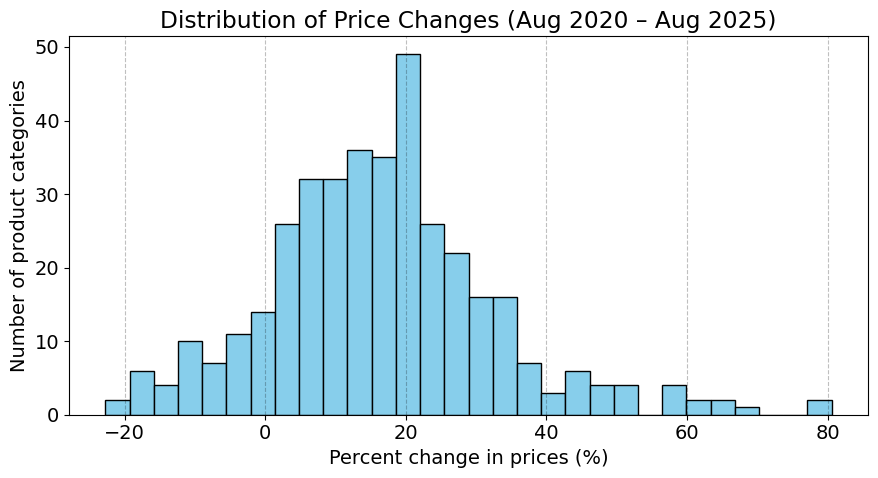

In [75]:
plt.figure(figsize=(9,5))
plt.hist(merged['pct_change'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Changes (Aug 2020 – Aug 2025)')
plt.xlabel('Percent change in prices (%)')
plt.ylabel('Number of product categories')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# We see that the distribution is pretty normal, but is affected by big outliers to the right,
# which is the products that saw huge price spikes

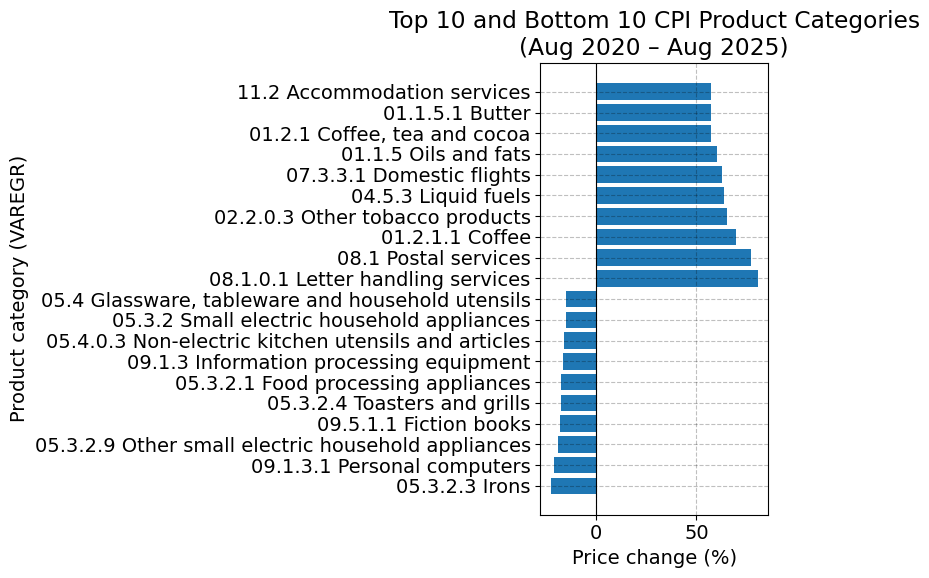

In [98]:
# We then want to show the top- and bottom 10 categories given their price changes in the period

# We first drop missing values
ranked = merged.dropna(subset=['pct_change'])

# Then we define top 10 and bottom 10 as pct changes
top10 = ranked.nlargest(10, 'pct_change')
bottom10 = ranked.nsmallest(10, 'pct_change')

# We can then create the plot
plot_df = pd.concat([bottom10, top10])
plt.figure(figsize=(8,6))
plt.barh(plot_df['VAREGR'], plot_df['pct_change'])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top 10 and Bottom 10 CPI Product Categories\n(Aug 2020 – Aug 2025)')
plt.xlabel('Price change (%)')
plt.ylabel('Product category (VAREGR)')
plt.tight_layout()
plt.show()

In [ ]:
# We here see, that the difference is quite large, where where mostly foods rose dramatically
# and electric aplliances fell in price.

# International comparison 2.1 & 2.2

a) The danish CPI and American HICP are equivalent in the sense, that they both report of the consumer price index in monthly terms and where the data is indexed to 2015=100. The difference is, that the HICP seems more steep, which may be caused by the inclusion/exclusion in one of the series. Nontheless the trends in the two series seems to be identical, so you should choose the HICP for international comparisons and the CPI for analyzing danish circumstances.

In [78]:
%%capture
%pip install git+https://github.com/alemartinello/dstapi
%pip install fredapi

import numpy as np
import pandas as pd

# APIs
from fredapi import Fred
from dstapi import DstApi

# plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

In [ ]:
# Find the correct path
with open('/Users/bh/Desktop/Programmering/fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

b) We want to compare the HICP across the selected countries

In [100]:
%%capture
# We search the code we need and give it names:

series = {
     "CP00MI15EA20M086NEST":"EUR",
     "CP0000DKM086NEST":"DEN",
     "CP0000USM086NEST":"USA",
     "CP0000FIM086NEST":"FIN",
}

for k in series.keys():
    display(fred.search(k)[['title','frequency','units']].T)

In [81]:
%%capture
# The data is downloaded:
data = {}
for code,name in series.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

In [82]:
# We want to plot the data, so we convert it to dataframes:

data = pd.DataFrame()
for code, label in series.items():
    data[label] = fred.get_series(code)


# Drop missing observations:
data = data.dropna(how='all')
print(data.head())

              EUR   DEN  USA    FIN
1999-12-01  74.79  76.3  NaN  75.29
2000-01-01  74.82  76.2  NaN  75.22
2000-02-01  75.06  76.6  NaN  75.80
2000-03-01  75.33  77.1  NaN  76.30
2000-04-01  75.41  77.3  NaN  76.44


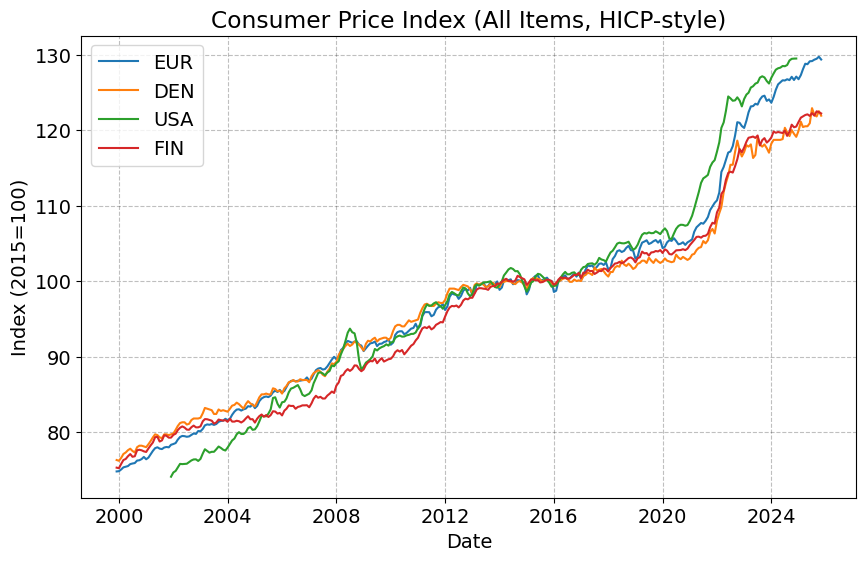

In [83]:
# Finally we plot the data:

plt.figure(figsize=(10,6))
for label in data.columns:
    plt.plot(data.index, data[label], label=label)

plt.title('Consumer Price Index (All Items, HICP-style)')
plt.xlabel('Date')
plt.ylabel('Index (2015=100)')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
# We see that the selected countries are expereriencing very similar levels of inflation throughout the period,
# though it seems that Denmark and Finland are below the EU average in 2025.

/var/folders/z7/tgkq7pjx7tvb8lys3k1y4ffw0000gn/T/ipykernel_56658/3038508581.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  inflation = data.pct_change(12) * 100 # First we compute the 12-month inflation rate


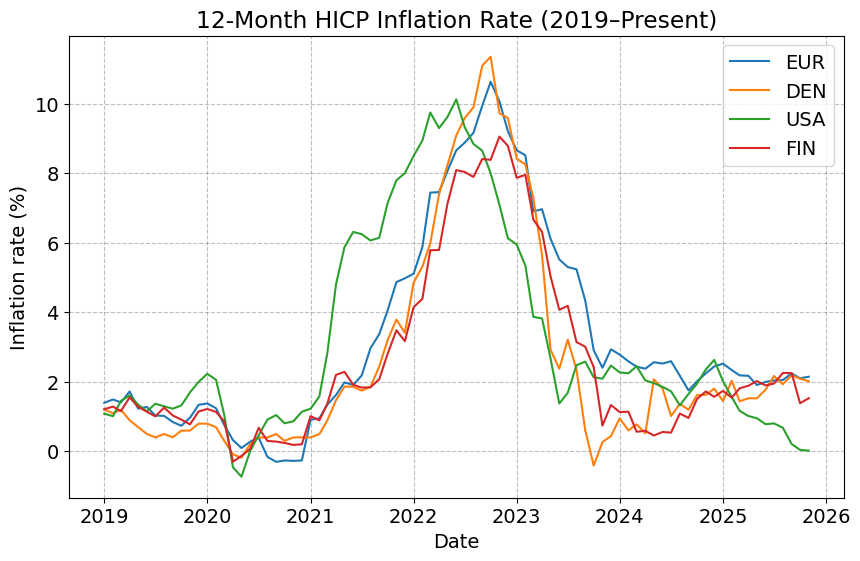

In [85]:
# We want to compute and compare the 12-month inflation rates across the countries:
inflation = data.pct_change(12) * 100 # First we compute the 12-month inflation rate
inflation = inflation.loc['2019-01-01':] # Specify the period

plt.figure(figsize=(10,6)) # plot inflation
for c in inflation.columns: # Each of the inflation columns contain a country/zone, which it loops for
    plt.plot(inflation.index, inflation[c], label=c)

plt.title('12-Month HICP Inflation Rate (2019–Present)')
plt.xlabel('Date')
plt.ylabel('Inflation rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
# we can then show some statistics about the inflation rates:
print(inflation.agg(['min', 'max', 'mean']).round(2))

        EUR    DEN    USA   FIN
min   -0.31  -0.42  -0.74 -0.31
max   10.64  11.36  10.13  9.06
mean   3.22   2.59   3.18  2.57


In [87]:
# We can see by the figure that the countries are experiencing similar inflation rates, but that the peak are at differnt times
# The statistics show that denmark experienced the highest peak inflation, while USA experienced the lowest minimum inflation rate.
# This could indicate differences in monetary policy responses between the countries.

# Extension 3

An extension of the inflation rate development, could be to show the development in real interest rates for different zones, based on nominal data from fred.

In [88]:
 # We search the code we need and give it names:

Inflation = {
     "CP00MI15EA20M086NEST":"EUR",
     "CP0000DKM086NEST":"DEN",
     "CP0000USM086NEST":"USA",
}
data = {}
for code,name in Inflation.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded CP00MI15EA20M086NEST from FRED and saved it as EUR            
Downloaded CP0000DKM086NEST from FRED and saved it as DEN            
Downloaded CP0000USM086NEST from FRED and saved it as USA            


In [89]:
# Combine data to DataFrame:
df_inflation = pd.concat(data.values(), axis=1)

# Compute 12-month percentage change (yearly inflation)
df_inflation = df_inflation.pct_change(12) * 100

# Drop missing values
df_inflation = df_inflation.dropna()

/var/folders/z7/tgkq7pjx7tvb8lys3k1y4ffw0000gn/T/ipykernel_56658/1404907156.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_inflation = df_inflation.pct_change(12) * 100


In [90]:
#We do the same for the interest rates:
Interest = {
     "IR3TIB01EZM156N":"EUR",
     "IR3TIB01DKM156N":"DEN",
     "FEDFUNDS":"USA",
}

data = {}
for code,name in Interest.items():
    var = fred.get_series(code)
    var.name = name
    data[name] = var
    print(f'Downloaded {code:15s} from FRED and saved it as {name:15s}')

Downloaded IR3TIB01EZM156N from FRED and saved it as EUR            
Downloaded IR3TIB01DKM156N from FRED and saved it as DEN            
Downloaded FEDFUNDS        from FRED and saved it as USA            


In [91]:
# Combine interest rate to DataFrame:
df_interest = pd.concat(data.values(), axis=1)
df_interest.index = pd.to_datetime(df_interest.index)
df_interest = df_interest.dropna()

In [92]:
# Then align the series:
df_combined = df_interest.join(df_inflation, how='inner', lsuffix='_rate', rsuffix='_infl')

# Create empty DataFrame for real interest rates
df_real = pd.DataFrame(index=df_combined.index)

# Real interest rates can then be computed:
for country in ['EUR', 'DEN', 'USA']:
    df_real[country] = df_combined[f'{country}_rate'] - df_combined[f'{country}_infl']


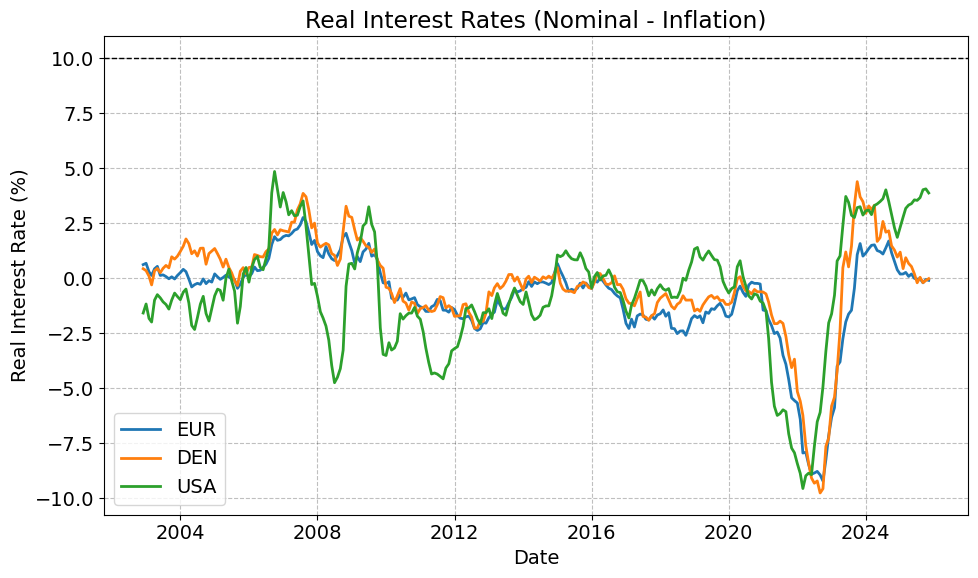

In [102]:
# Lastly the series are plotted:

plt.figure(figsize=(10,6))
for col in df_real.columns:
    plt.plot(df_real.index, df_real[col], label=col, linewidth=2)

plt.title("Real Interest Rates (Nominal - Inflation)")
plt.ylabel("Real Interest Rate (%)")
plt.xlabel("Date")
plt.axhline(10, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
# This figure shows the development of the real interest rates (Nominal - Inflation) for 3 seleceted countries/zones
# We see that the real interest rates rose sharply around 2021 which means inflation rose more than nominal interest rate at that point.